## Variational inference
We will fit a simple 1D Bayesian linear regression with known variance. The likelihood is given by,
$$y \sim \mathcal{N}(w_0 + w_1x,\ 1),$$
and the prior is,
$$w_0, w_1 \sim N(0,\ I).$$


In [14]:
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import norm, multivariate_normal
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.bijections import Affine
from flowjax.distributions import StandardNormal
from flowjax.train.variational_fit import fit_to_variational_target
from flowjax.train.losses import ElboLoss
import optax

# generate observed data
data_key = jr.PRNGKey(1)
w_0 = 0.5
w_1 = -0.5

n = 20
key, x_key, noise_key = jr.split(data_key, 3)
x = jr.uniform(x_key, shape=(n,)) * 4 - 2
y = w_0 + w_1 * x + jr.normal(noise_key, shape=(n,))

We can define our objective, via the unnormalised posterior distribution. This maps samples $w$ to a vector of unnormalised probabilites

In [15]:
def unormalized_posterior(w):
    likelihood = norm.logpdf(y, w[0] + x * w[1]).sum()
    prior = norm.logpdf(w).sum()  # Standard normal prior
    return (likelihood + prior).sum()

We define and fit the flow. Note that we set `invert=False`, which loosely speaking specifies that we prioritise faster `sample` and `sample_and_log_prob` methods for the flow, instead of a fast `log_prob` method. The evidence lower bound (ELBO) approximation is computed using the `sample_and_log_prob` method.

In [16]:
loss = ElboLoss(unormalized_posterior, num_samples=50)

key, flow_key, train_key = jr.split(key, 3)
flow = MaskedAutoregressiveFlow(
    flow_key, base_dist=StandardNormal((2,)), transformer=Affine(), invert=False
)

# Train the flow variationally
optimizer = optax.chain(optax.adam(1e-2), optax.clip_by_global_norm(1))
flow, losses = fit_to_variational_target(
    train_key, flow, loss, optimizer=optimizer, steps=200
)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 103.91it/s, loss=33.1]


We can now visualise the learned posterior, here using contour plots to show the approximate (orange) and true (blue) posterior

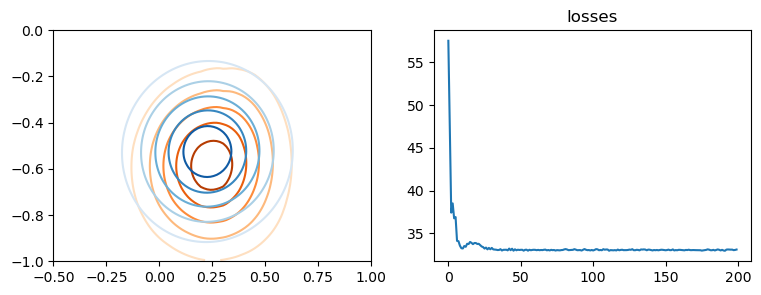

In [29]:
def plot_density(
    ax, density_fn, xmin, xmax, ymin, ymax, n=100, levels=None, cmap="Blues"
):
    xvalues = jnp.linspace(xmin, xmax, n)
    yvalues = jnp.linspace(ymin, ymax, n)
    X, Y = jnp.meshgrid(xvalues, yvalues)

    points = jnp.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])

    log_prob = density_fn(points).reshape(n, n)
    prob = jnp.exp(log_prob)

    ax.contour(
        prob, levels=levels, extent=[xmin, xmax, ymin, ymax], origin="lower", cmap=cmap
    )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


fig, axes = plt.subplots(ncols=2, figsize=(9, 3))
kwargs = dict(levels=5, xmin=-0.5, xmax=1, ymin=-1, ymax=0)

plot_density(axes[0], flow.log_prob, cmap="Oranges", **kwargs)

def true_posterior_log_prob(theta, x):
    x = jnp.vstack([jnp.ones_like(x), x])  # full design matrix
    cov = jnp.linalg.inv(x.dot(x.T) + jnp.eye(2))
    mean = cov.dot(x).dot(y)
    return multivariate_normal.logpdf(theta, mean, cov)

plot_density(
    ax=axes[0],
    density_fn=lambda theta: true_posterior_log_prob(theta, x=x),
    cmap="Blues",
    **kwargs)

axes[1].set_title("losses")
axes[1].plot(losses)


### Amortized variational inference
If we have multiple observations, we can use amortized variational inference to fit a single
conditional density estimator to approximate the posteriors for all the observations. This
technique can be used to avoid performing inference seperately for each observation.
This is essentially the same as before except:

1. We define the target to take in the observation as an argument.
2. We use a conditional distribution as the variational distribution.
3. We pass the set of observations to the ``fit_to_variational_target`` function.

In [34]:
key, subkey = jr.split(key) 
many_x = jr.uniform(subkey, shape=(10, n)) * 4 - 2

def unormalized_posterior(w, x):
    likelihood = norm.logpdf(y, w[0] + x * w[1]).sum()
    prior = norm.logpdf(w).sum()  # Standard normal prior
    return (likelihood + prior).sum()

loss = ElboLoss(unormalized_posterior, num_samples=1)

key, subkey = jr.split(key)

flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist=StandardNormal((2,)),
    transformer=Affine(),
    cond_dim=many_x.shape[1],
    invert=False
)

key, subkey = jr.split(key)
flow, losses = fit_to_variational_target(
    subkey, flow, loss, optimizer=optimizer, steps=200, condition=many_x
)

100%|██████████| 200/200 [00:02<00:00, 77.24it/s, loss=34.9] 


Again, plotting the results, for simplicitly just looking at the posterior learned for one of the observations

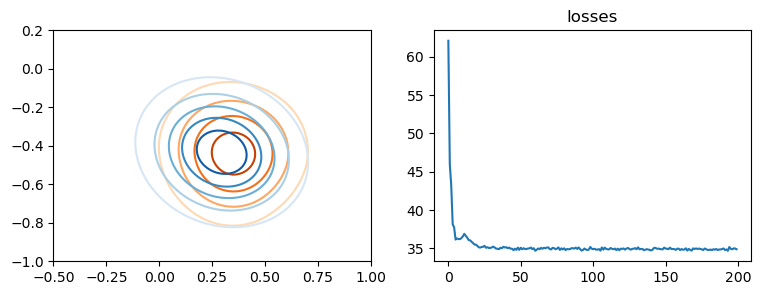

In [41]:

fig, axes = plt.subplots(ncols=2, figsize=(9, 3))
kwargs = dict(levels=5, xmin=-0.5, xmax=1, ymin=-1, ymax=0.2)

# Plot posterior approximation
plot_density(
    axes[0],
    density_fn=lambda theta: flow.log_prob(theta, many_x[0]),
    cmap="Oranges",
    **kwargs)


plot_density(
    ax=axes[0],
    density_fn=lambda theta: true_posterior_log_prob(theta, x=many_x[0]),
    cmap="Blues",
    **kwargs)

axes[1].set_title("losses")
axes[1].plot(losses)